In [201]:
import pathlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage.feature import hog

In [202]:
data_dir = pathlib.Path('./output/rgb')
# data_dir = pathlib.Path('./output/rgb_no_circle_det')
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

34


In [203]:
from skimage.feature import SIFT
from skimage import exposure
from skimage.color import rgb2gray, gray2rgb

def sift_features_vector(src, image_path, height_map=None):
    src = rgb2gray(src)
    img_adapteq = exposure.equalize_adapthist(src, clip_limit=0.03)
    print(img_adapteq.shape)
    descriptor_extractor = SIFT()
    # descriptor_extractor = ORB(n_keypoints=50)
    descriptor_extractor.detect_and_extract(img_adapteq)
    keypoints = descriptor_extractor.keypoints
    descriptors = descriptor_extractor.descriptors
    
    # random select 100 keypoints
    # random_keypoints = np.random.randint(0, len(keypoints), 200) # DMMP
    random_keypoints = np.random.randint(0, len(keypoints), 500) # MP
    # random_keypoints = np.random.randint(0, len(keypoints), 1000) # MP
    keypoints = keypoints[random_keypoints]
    descriptors = descriptors[random_keypoints]
    
    height_value = []
    if height_map is not None:
        for i in range(len(keypoints)):
            height = height_map[int(keypoints[i][0]), int(keypoints[i][1])]
            height_value.append(height)
    
    plt.imshow(img_adapteq, cmap='gray')
    plt.scatter(keypoints[:, 1], keypoints[:, 0],
                facecolors='none', edgecolors='r')
    plt.savefig('./output/sift/%s' % (image_path))
    plt.close()
    if height_map is not None:
        descriptors = np.hstack((descriptors, np.array(height_value).reshape(-1, 1)))
    print(descriptors.shape)
    return descriptors

D:\UserTemp\ipykernel_21416\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



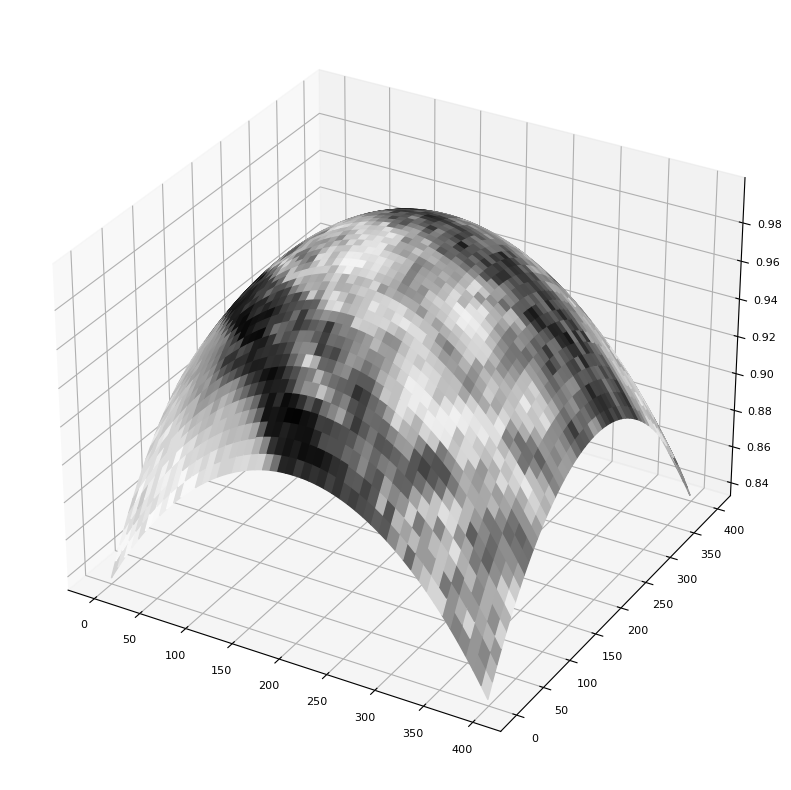

In [204]:
def generate_height_map(size):
    # Define the radius of the sphere
    # offset = 0
    # offset = 175
    offset = 315
    size = size + 2*offset

    r = 1.0

    # Create a 2D grid of x and y coordinates
    x, y = np.meshgrid(np.linspace(-r, r, size), np.linspace(-r, r, size))

    # Calculate the corresponding z coordinates
    # Note: For points outside the sphere, this will be NaN
    z = np.sqrt(r**2 - x**2 - y**2)

    # We set points outside the sphere to zero height for visualization
    z[np.isnan(z)] = 0

    z = z[offset:size-offset, offset:size-offset]

    return z
# visualise the height map in 3D
height_map = generate_height_map(400)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create the x, y, and z coordinate arrays. We use 
# numpy's broadcasting to do all the hard work for us.
# We could shorten this even more by using np.meshgrid.
x = np.arange(height_map.shape[0])
y = np.arange(height_map.shape[1])
x, y = np.meshgrid(x, y)
z = height_map

# Load the image
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('./output/rgb/M-DMMP- NaBF4-10-6M-1.jpg')
image = rgb2gray(image)
image = exposure.equalize_adapthist(image, clip_limit=0.03)
image = gray2rgb(image)
height, width = image.shape[:2]
resize_image = cv2.resize(src=image, dsize=(int(width / 2), int(height / 2)))
resize_image = resize_image[50:450, 50:450]

# Map the image to the surface
ax.plot_surface(x, y, z, facecolors=image, shade=False)

plt.show()

In [205]:
import os
from sklearn.model_selection import train_test_split

rotation_aug = False

experiment_with_gray_scale = True

use_entire_dataset = True

load_all_images = False

use_height_map = True

distraction_merge, distraction_merge_to_one, original_merge_to_one = False, False, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, True, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = True, False, False
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, False, True
# distraction_merge, distraction_merge_to_one, original_merge_to_one = False, True, True
# distraction_merge, distraction_merge_to_one, original_merge_to_one = True, False, True

os.makedirs('./output/sift', exist_ok=True)

# Data selection
# molecular_imprinting_name = 'DMMP'
molecular_imprinting_name = 'MP'
# molecular_imprinting_name = 'MPA'
x = []
y = []
for path in data_dir.glob('*.jpg'):
    if not load_all_images:
        if path.name.split('-')[1] != molecular_imprinting_name and path.name.split('-')[1].split('(')[0] != molecular_imprinting_name:
                continue
    src = cv2.imread(str(path))
    height, width = src.shape[:2]
    center = (width / 2, height / 2)
    if rotation_aug:
        for i in range(3):
            rotation_matrix = rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=90 * i, scale=1)
            rotated_image = cv2.warpAffine(src=src, M=rotate_matrix, dsize=(width, height))
            resize_image = cv2.resize(src=src, dsize=(int(width / 2), int(height / 2)))
            # crop image 200x200
            resize_image = resize_image[150:350, 150:350]
            if use_height_map:
                height_map = generate_height_map(200)
                resize_image = np.dstack((resize_image.astype(np.float32), height_map))
            feature_vector = sift_features_vector(resize_image, os.path.basename(path))
            x.append(feature_vector)
            y.append(path.name.split('-')[2].replace(' ', ''))
    else:
        resize_image = cv2.resize(src=src, dsize=(int(width / 2), int(height / 2)))
        # crop image 200x200
        resize_image = resize_image[50:450, 50:450]
        if use_height_map:
            height_map = generate_height_map(400)
        else:
            height_map = None
        feature_vector = sift_features_vector(resize_image, os.path.basename(path), height_map=height_map)
        x.append(feature_vector)
        if load_all_images:
            label_name = path.name.split('-')[1].split('(')[0] + '-' + path.name.split('-')[2].replace(' ', '')
            if label_name.split('-')[0] != label_name.split('-')[1]:
                if distraction_merge or distraction_merge_to_one:
                    if distraction_merge_to_one:
                        label_name = 'distraction'
                    else:
                        label_name = label_name.split('-')[0] + '-distraction'
            elif label_name.split('-')[0] == label_name.split('-')[1]:
                if original_merge_to_one :
                    label_name = 'original'
        else:
            if distraction_merge or distraction_merge_to_one:
                if path.name.split('-')[2].split('(')[0] != molecular_imprinting_name:
                    if distraction_merge_to_one:
                        label_name = 'distraction'
                    else:
                        label_name = path.name.split('-')[1].split('(')[0] + '-distraction'
                else:
                    label_name = path.name.split('-')[2].replace(' ', '')
            else:
                label_name = path.name.split('-')[2].replace(' ', '')
        y.append(label_name)
        
x = np.array(x)
y = np.array(y)
print('data loaded x=%i' % (len(x)))
print('data loaded y=%i' % (len(y)))

D:\UserTemp\ipykernel_21416\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



(400, 400)
(500, 129)
(400, 400)


D:\UserTemp\ipykernel_21416\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



(500, 129)
(400, 400)


D:\UserTemp\ipykernel_21416\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



(500, 129)
(400, 400)


D:\UserTemp\ipykernel_21416\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



(500, 129)
(400, 400)


D:\UserTemp\ipykernel_21416\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



(500, 129)
(400, 400)


D:\UserTemp\ipykernel_21416\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



(500, 129)
(400, 400)


D:\UserTemp\ipykernel_21416\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



(500, 129)
(400, 400)


D:\UserTemp\ipykernel_21416\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



(500, 129)
(400, 400)


D:\UserTemp\ipykernel_21416\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



(500, 129)
(400, 400)


D:\UserTemp\ipykernel_21416\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



(500, 129)
(400, 400)


D:\UserTemp\ipykernel_21416\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



(500, 129)
(400, 400)


D:\UserTemp\ipykernel_21416\1973192219.py:15: RuntimeWarning:

invalid value encountered in sqrt



(500, 129)
data loaded x=12
data loaded y=12


In [206]:
print(x.shape)
print(y.shape)

(12, 500, 129)
(12,)


In [207]:
x = x.reshape(x.shape[0], -1)
print(x.shape)

(12, 64500)


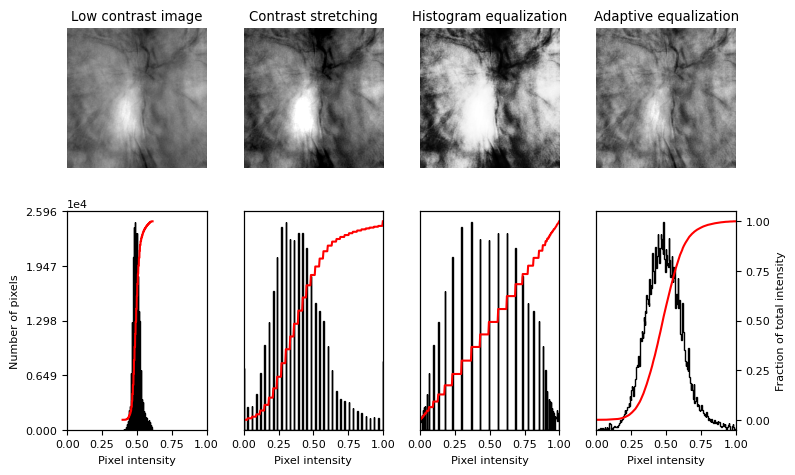

In [208]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = cv2.imread('./output/rgb/M-DMMP- NaBF4-10-6M-1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img[200:800, 200:800]

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

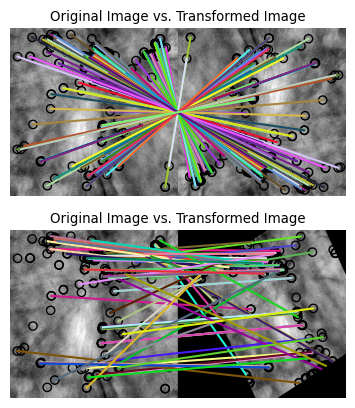

In [209]:
from skimage import data
from skimage import transform
from skimage.feature import match_descriptors, ORB, plot_matches
from skimage.color import rgb2gray
import matplotlib.pyplot as plt


# img1 = rgb2gray(data.astronaut())
img1 = img_adapteq
img2 = transform.rotate(img1, 180)
tform = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                                  translation=(0, -200))
img3 = transform.warp(img1, tform)

descriptor_extractor = ORB(n_keypoints=200)

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img3)
keypoints3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)

fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
ax[0].axis('off')
ax[0].set_title("Original Image vs. Transformed Image")

plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
ax[1].axis('off')
ax[1].set_title("Original Image vs. Transformed Image")


plt.show()

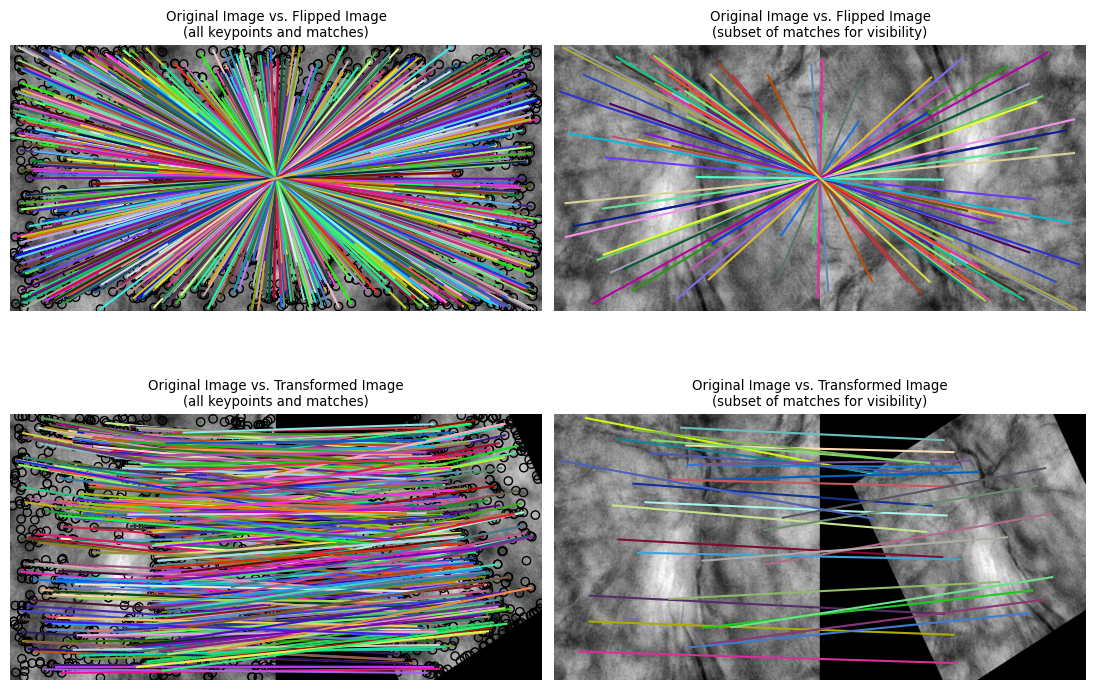

In [210]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT

# img1 = rgb2gray(data.astronaut())
img1 = img_adapteq
img2 = transform.rotate(img1, 180)
tform = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                                  translation=(0, -200))
img3 = transform.warp(img1, tform)

descriptor_extractor = SIFT()

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img3)
keypoints3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, max_ratio=0.6,
                              cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, max_ratio=0.6,
                              cross_check=True)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))

plt.gray()

plot_matches(ax[0, 0], img1, img2, keypoints1, keypoints2, matches12)
ax[0, 0].axis('off')
ax[0, 0].set_title("Original Image vs. Flipped Image\n"
                   "(all keypoints and matches)")

plot_matches(ax[1, 0], img1, img3, keypoints1, keypoints3, matches13)
ax[1, 0].axis('off')
ax[1, 0].set_title("Original Image vs. Transformed Image\n"
                   "(all keypoints and matches)")

plot_matches(ax[0, 1], img1, img2, keypoints1, keypoints2, matches12[::15],
             only_matches=True)
ax[0, 1].axis('off')
ax[0, 1].set_title("Original Image vs. Flipped Image\n"
                   "(subset of matches for visibility)")

plot_matches(ax[1, 1], img1, img3, keypoints1, keypoints3, matches13[::15],
             only_matches=True)
ax[1, 1].axis('off')
ax[1, 1].set_title("Original Image vs. Transformed Image\n"
                   "(subset of matches for visibility)")

plt.tight_layout()
plt.show()

DATA MINING

In [211]:
from sklearn.manifold import TSNE

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# sc.fit(x)
#
# x = sc.transform(x)
# x_test = sc.transform(x_test)
# x_train = sc.transform(x_train)

pca = TSNE(n_components=3, learning_rate='auto', init='pca', perplexity=3, random_state=1)
if use_entire_dataset:
    x_train_pca = pca.fit_transform(x)
    y_train = y
else:
    x_train_pca = pca.fit_transform(x_train)
    y_train = y_train
x_train_pca

array([[ -72.436035, -114.31961 ,   67.47446 ],
       [  18.30141 ,   18.981981,  112.75734 ],
       [ -98.387375,   55.14764 ,   48.57099 ],
       [  40.826546,   63.52659 ,  -18.857218],
       [ -46.42792 ,  124.73742 ,  -14.142178],
       [  74.36364 ,  -53.59103 ,  -62.44092 ],
       [ -47.950626, -104.37332 ,  -53.490864],
       [  30.308794,   56.77072 , -100.207855],
       [  34.37766 , -120.488304,   22.243824],
       [  18.46091 ,  -28.112087,  -13.876459],
       [ -47.531727,  -37.856518,   44.32848 ],
       [ -26.992245,   21.693096,   29.838968]], dtype=float32)

In [212]:
# print('total explain ratio=%s' % sum(pca.explained_variance_ratio_[:3]))
# input('%s %s total explain ratio=%s' % (
#     molecular_imprinting_name, str((int(1000 / pixels_per_cell[0]), int(1000 / pixels_per_cell[0]))), sum(pca.explained_variance_ratio_[:3])))

In [213]:
import pandas as pd
n_components=3
df = pd.DataFrame(x_train_pca, columns=[f"PC{i + 1}" for i in range(n_components)])
label_list = []

for i in range(len(x_train_pca)):
    label_list.append(y_train[i])
    # if y[i] == 'DMMP':
    #     label_list.append('MP, DMMP, MPA')
    # elif y[i] == 'NaBF4':
    #     label_list.append('NaBF4')
    # elif y[i] == 'MP':
    #     label_list.append('MP, DMMP, MPA')
    # elif y[i] == 'MPA':
    #     label_list.append('MP, DMMP, MPA')
    # elif y[i] == 'Original':
    #     label_list.append('Original')
    # elif y[i] == 'KF6P':
    #     label_list.append('KF6P')
    # elif y[i] == 'MP, DMMP, MPA':
    #     label_list.append('MP, DMMP, MPA')
    # else:
    #     print('ERROR')
df['label'] = label_list
df

,PC1,PC2,PC3,label
0,-72.436035,-114.319611,67.474457,MP
1,18.301411,18.981981,112.757339,MP
2,-98.387375,55.147640,48.570992,MP
3,40.826546,63.526588,-18.857218,MP
4,-46.427921,124.737419,-14.142178,MP
5,74.363640,-53.591030,-62.440922,NaBF4
6,-47.950626,-104.373322,-53.490864,NaBF4
7,30.308794,56.770721,-100.207855,NaBF4
8,34.377659,-120.488304,22.243824,NaBF4
9,18.460911,-28.112087,-13.876459,KF6P


In [214]:
import plotly.io as pio

print(pio.templates)
pio.templates.default = 'plotly'

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']



In [215]:
import random
import plotly.express as px

fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='label', symbol='label', title='%s SIFT' % (molecular_imprinting_name), color_discrete_map={
                "DMMP": "red",
                "NaBF4": "green",
                "KF6P": "blue",
                "MPA": "goldenrod",
                "MP": "purple"},
                symbol_sequence= ['circle', 'circle', 'circle', 'circle'])
fig.update_traces(marker=dict(size=6),selector=dict(mode='markers'))
fig.update_layout(scene=dict(
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False),
    zaxis=dict(showticklabels=False)
))
fig.show()

In [216]:
raise NotImplementedError

NotImplementedError: 

Final Model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification

class TestTSNE(BaseEstimator, TransformerMixin):
    def __init__(self,n_components,random_state=None,method='exact'):
        self.n_components = n_components
        self.method = method
        self.random_state = random_state

    def fit(self, X, y = None):
        ts = TSNE(n_components = self.n_components, learning_rate='auto', init='pca', perplexity=3)
        self.X_tsne = ts.fit_transform(X)
        return self

    def transform(self, X, y = None):
        return X

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

estimators = [('reduce_dim', PCA(n_components=8)), ('clf', SVC())]
pipe = Pipeline(estimators)
pipe.fit(x_train, y_train)
print(pipe.score(x_test, y_test))
print(classification_report(y_test, pipe.predict(x_test)))

In [ ]:
estimators = [('std', StandardScaler()),('reduce_dim', TestTSNE(n_components=3)), ('clf', KNeighborsClassifier(1))]
pipe = Pipeline(estimators)
pipe.fit(x_train, y_train)
print(pipe.score(x_test, y_test))
print(classification_report(y_test, pipe.predict(x_test)))

In [ ]:
estimators = [('reduce_dim', PCA(n_components=4, svd_solver='full')), ('clf', KNeighborsClassifier(1))]
pipe = Pipeline(estimators)
pipe.fit(x_train, y_train)
print(pipe.score(x_test, y_test))
print(classification_report(y_test, pipe.predict(x_test)))

In [ ]:
best = (0, 0)
for i in range(1, 4):
    estimators = [('reduce_dim', PCA(n_components=i, svd_solver='full')), ('clf', KNeighborsClassifier(1))]
    pipe = Pipeline(estimators)
    pipe.fit(x_train, y_train)
    score = pipe.score(x_test, y_test)
    if score > best[1]:
        best = (i, score)
print(best)

In [ ]:
best = (0, 0)
for i in range(1, 4):
    estimators = [('reduce_dim', PCA(n_components=i, svd_solver='full')), ('clf', SVC())]
    pipe = Pipeline(estimators)
    pipe.fit(x_train, y_train)
    score = pipe.score(x_test, y_test)
    if score > best[1]:
        best = (i, score)

print(best)

In [ ]:
from matplotlib import cm
# Wrong classification visualization
import matplotlib.image as mpimg

predict_result = pipe.predict(x_test)
wrong_classification = []
wrong_classification_label = []
for i in range(len(predict_result)):
    if predict_result[i] != y_test[i]:
        wrong_classification.append(i)
        wrong_classification_label.append(y_test[i])
print(wrong_classification_label)
for i, path in enumerate(data_dir.glob('*.jpg')):
    if i in wrong_classification:
        img = cv2.imread(str(path))
        label = wrong_classification_label[wrong_classification.index(i)]
        cv2.imshow(label, img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [ ]:
# Reverse pattern with PCA
pca = PCA(n_components=3)
pca.fit(x_train)

guess_data = np.array([2, 1.5, -0.25])
data_original = np.dot(guess_data, pca.components_)  # inverse_transform
data_original = np.reshape(data_original, (256, 9))
data_original